# Homework 9 - Andrea Lazzari

## Hopfield Netowrks

A Hopfield network is a type of recurrent neural network that was developed by John Hopfield in the 1980s. It is a type of associative memory system, which means that it is able to learn and store a set of patterns, and can then recall those patterns when presented with partial or noisy versions of them.

Hopfield networks consist of a set of $N$ interconnected units, each of which can take on a binary value, with a *spin-like* state $\sigma_i$: 

$$

\sigma_i =
\begin{cases}
+1 \quad \quad \text{if the unit is active} \\
-1 \quad \quad \text{if the unit is inactive}

\end{cases}

$$

The units are connected to each other via a set of weighted connections, which can either be excitatory (positive) or inhibitory (negative). When a pattern is presented to the network, the units are activated in a way that is determined by the strengths of the connections between them. The network then adjusts the strengths of these connections in order to better encode the presented pattern.

When the network is later presented with a partial or noisy version of a stored pattern, it can "recall" the original pattern by adjusting the activations of the units in a way that is consistent with the stored patterns.  

This process continues until the network reaches a stable state, at which point the activations of the units should closely match those of the original stored pattern.

Hopfield networks have been used for a variety of tasks, including pattern recognition, optimization, and error correction. However, they are limited by the fact that they can only store a limited number of patterns, and that they can sometimes become trapped in states that are not stable patterns (a phenomenon known as "spurious states").

---

### The Framework

The network dynamics is defined as follows:

1 - Pick a random unit $i$, with state $\sigma_i$  

2 - If the *nearest neighbours* of $i$ transmit to it a sufficiently strong signal (above a characteristic threshold $h_i$), then the unit $i$ will be activated (i.e. $\sigma_i = +1$) otherwise it will be deactivated (i.e. $\sigma_i = -1$):
$$

\sum_{j \in nn(i)} J_{ij} \cdot \sigma_j < h_i \quad \to \quad \sigma_i = -1 \\
\sum_{j \in nn(i)} J_{ij} \cdot \sigma_j \geq h_i \quad \to \quad \sigma_i = +1 
$$

3 - Reiterate the process until the network reaches a stable state


The energy of a Hopfield network is given by:
$$
\varepsilon = -\dfrac{1}{2} \sum_{i,j=1}^{N} J_{ij} \cdot \sigma_i \sigma_j + \sum_{i=1}^{N} h_i \cdot \sigma_i
$$

The energy of the network is a measure of how well the current activations match the stored patterns.  

The Hopfield dynamics is equivalent to a Metropolis algorithm at $T=0$; it will tend to adjust the activations of the units in order to **minimize** the energy.

---

### The Hopfield Rule

The Hopfield rule is a set of rules that can be used to determine the weights of the connections between the units in a Hopfield network.

The Hopfield rule states that the weights of the connections between the units should be set to the *average* of the outer products of the states of the units in the stored patterns $v^{\mu}$.

$$
J_{ij} = \dfrac{1}{M} \sum_{\mu=1}^{M} v_i^{(\mu)} \cdot v_j^{(\mu)}
$$

where $M$ is the number of stored patterns, and $v_i^{(\mu)}$ is the state of unit $i$ in pattern $\mu$.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import PIL.Image as Image 
import matplotlib.image as img

In [2]:
# read an image and convert it to a binary pattern os size [Lx, Ly]: 
# arguments = figurename, final size=[Lx, Ly]
def readPatterns(fname, size):
	this_img = Image.open(fname) # open colour image
	this_img = this_img.convert('1') # convert image to black and white
	this_img = this_img.resize(size=[size[0],size[1]]) # resize it to have the dimensions [Lx, Ly]
	this_img.save("%s_converted.png"%fname) # save converted image

	# plot the original and the converted file
	fig = plt.figure()

	# subplot on the left - original figure
	fig.add_subplot(1,2,1)		
	original = img.imread(fname)
	plt.imshow(original)
	plt.title("original")
	plt.axis('off')

	# subplot on the right - converted figure
	matrix = img.imread("%s_converted.png"%fname) # re-read from the file and convert it to a matrix of [0.,1.]
	matrix = 2*matrix-1 # convert from [0.,1.] -> [-1,1]
	fig.add_subplot(1,2,2)		
	plt.matshow(matrix, cmap=plt.cm.gray,fignum=0)
	plt.axis('off')
	plt.title("simplified")
	plt.show()
	
	# Return the pattern as a 1D vector (not as a 2D a matrix)
	return matrix.flatten()
	
#####################################################################################

In [3]:
class HopfieldNet:
	# initialize: 
	# arguments = number of neurons, list of patterns (vector of M components, each element of the pattern has to be an array of -1,+1 of size N)
	def __init__(self, N, patterns):
		self.N = N
		self.time_elapsed = 0.
		
		self.w = np.zeros([N,N]) # weights
		self.h = np.zeros(N) # threshold functions
		
		self.s = -np.ones(N) # default configuration = s[i]=-1
		
		# HEBBIAN RULE (h_i = 0., w_{ij} = sum_{k=1,...,M} s_i^k*s_j^k / M)
		print("The network is learning...")
		self.M = len(patterns)
		for k in range(self.M):
			print("pattern ", k)
			# this is not efficient, but we could use it anyway:
#			for i in range(self.N):
#				for j in range(self.N):
#					self.w[i,j] += patterns[k][i]*patterns[k][j]/(1.*self.M)

			# it is more efficient to use built-in functions:
			self.w += np.outer(patterns[k],patterns[k])/(1.*self.M)


		print("Done!")
	
	
#		# COMPUTE THE ENERGY - As before, I avoid loops and use efficient functions
		self.E = -0.5*np.sum(self.w) - np.sum(self.h) # energy for s_i = -1
		
		return

	# given and input s=[s_1,s_2,...,s_N], set the state of the network and recompute the energy
	def set_state(self, sinput):
		self.s = np.copy(sinput)

		# COMPUTE THE ENERGY - I use efficient functions rather than loops
		s2 = np.outer(self.s, self.s) # this returns a matrix s2[i,j]=s[i]*s[j]
		self.E = -0.5*np.sum(self.w*s2) + np.sum(self.h*self.s)
	
		return

	# evolve the state of the networks doing a number "steps" of Monte Carlo steps
	def evolve(self, steps):
		for t in range(steps):
			i = np.random.randint(self.N) # choose one node randomly
			
			sum_wijsj = np.sum(self.w[i,:]*self.s) # compute the argument of the activation function			
			if sum_wijsj < self.h[i]: # below the threshold
				self.s[i] = -1
			else: # above the threshold
				self.s[i] = 1
				
		return
#######################################################################

Reading images and converting to binary patterns...


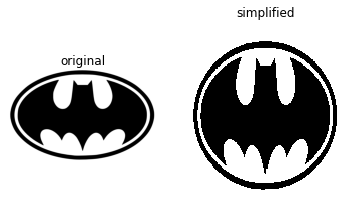

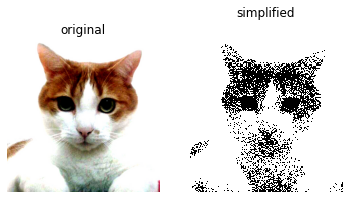

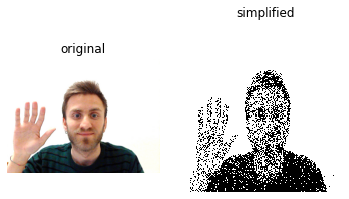

Done!


In [4]:
# dimensions of the images
Lx = Ly = 150
N = Lx*Ly # number of neurons


## STEP 1: READ THE IMAGES AND CONVERT THEM TO BINARY PATTERNS

# list of images that I want to store in my network
files = ["stored/batman.png", "stored/cat.jpg", "stored/jordi.jpg"]

print("Reading images and converting to binary patterns...")
patterns = []
for fname in files:
	patterns.append(readPatterns(fname, size=[Lx,Ly]))
print("Done!")



In [7]:
## STEP 2: CREATE THE NETWORK AND LEARN THE PREVIOUS PATTERNS
mynet = HopfieldNet(N, patterns)

The network is learning...
pattern  0
pattern  1
pattern  2
Done!


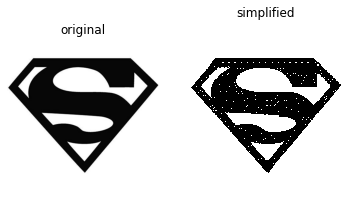

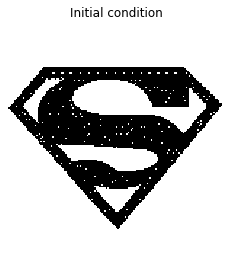

In [9]:
## STEP 3: SET ANOTHER INPUT PATTERN AS INITIAL CONDITION

newinput = readPatterns("inputs/superman.jpg", size=[Lx,Ly]) # read the pattern from a file
mynet.set_state(newinput) # set the pattern as the initial condition of the network 

plt.matshow(np.resize(mynet.s,(Lx,Ly)), cmap=plt.cm.gray, fignum=0) # read the state (we reconvert it to a Lx*Ly matrix) and plot it
plt.title("Initial condition")
plt.axis('off')
plt.show()


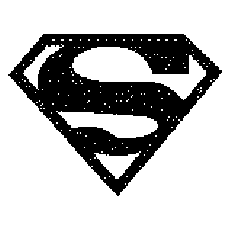

In [10]:
## STEP 4: EVOLVE THE NETWORK!
#################### ANIMATION #################################

# animation
TOTAL_FRAMES = 100000 # number of frames of the animation
DT_FRAMES = 100 # duration of each frame (ms): we can accelerate or slow down the animation changing this

fig = plt.figure()	
fig_mat = plt.matshow(np.resize(mynet.s,(Lx,Ly)), cmap=plt.cm.gray, fignum=0) # see more colormaps in https://matplotlib.org/examples/color/colormaps_reference.html
plt.axis('off')

# functions used to produce the animation
def animation_init(): # how to initialize the animation (if we put things here they will be fix in the animation) 
	fig_mat.set_data(np.resize(mynet.s,(Lx,Ly)))
	return fig_mat

def animation_update(i) :
	mynet.evolve(steps = int(N/10))
	fig_mat.set_data(np.resize(mynet.s,(Lx,Ly)))
	return fig_mat
	

In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from matplotlib.animation import FuncAnimation, PillowWriter

In [57]:
# generate the animation
ani = animation.FuncAnimation(fig, animation_update, 
                              blit=False, repeat=False) # blit is used to make simulation faster
plt.show()

---

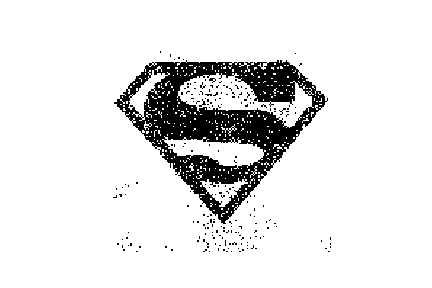

In [12]:
gifPath = "GIF/Evolution_Superman.gif" 
# Display GIF
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

Given the superman image as input, we can see that the network recalls the most similar pattern that is had stored previously, in this case the cat image.

---

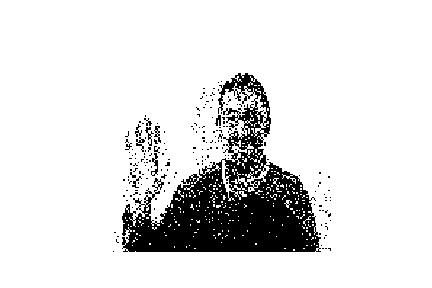

In [13]:
gifPath = "GIF/Evolution_Samir.gif" 
# Display GIF
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

Also with `samir.jpg` image as input the network recalls the most similar pattern that is had stored previously, in this case the `jordi.jpg` image.
We can expect this result since the two subjects of the images are in the same position and have the similar expression.

---

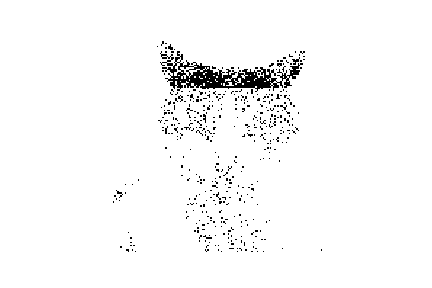

In [14]:
gifPath = "GIF/Evolution_Cat3.gif" 
# Display GIF
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

Given the image of the cat's ears as input, we can see that the network can afford in recalling the entire cat image that was stored.

---

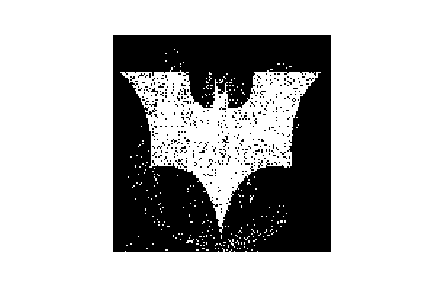

In [15]:
gifPath = "GIF/Evolution_batman01.gif" 
# Display GIF
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

Given a different batman symbol w.r.t. the one stored as input, we can see that the network tries to recall the one which is already stored in memory (above all we can observe this fact from the reconstruction of the edge at the bottom) but probably it has no enough time or it is not sufficiently powerful.

---